# Building an OCR from scratch

So in this tutorial, I will give you a basic code walkthrough for building a simple OCR. OCR as might know stands for optical character recognition or in layman terms it means text recognition. Text recognition is one of the classic problems in computer vision and is still relevant today. One of the most important applications of text recognition is the digitization of old manuscripts. Physical copies of books and manuscripts are prone to degradations. With time, the printed characters start to fade. On simple way to preserve such documents is to make a digital copy of it and store it in the cloud or local hard drive which would ensure their continuance. Similarly, text recognition can also be used for licence plate recognition and can also be used in forensics in terms of handwriting recognition. 

Okay, now that I have given you enough motivation as to why OCR is important, let me show you how you can build one. 
So first things first, I'll start with listing down some of the essential packages that you would need to build your first OCR. We will be working with PyTorch as it is one of the most efficient deep learning libraries present. The other packages are as follows:

* Pytorch 1.5
* Matplotlib
* Tqdm
* textdistance
* lmdb

You can install them either via a pip or conda. I will also be providing a requirements.txt file which you can find in my Github repo. Do a simple `pip install -r requirements` and you are set to go.

## Setting up the Data

We will start our project by importing the libraries. But before that we need data. Now, you are free to use any text image data you might like and for that, you might need to build your own data loader. However, in the interest of keeping things simple, we will be using a neat little package called `trdg`, which is a synthetic image generator for OCR. You can find all the relevant information regarding this package on its [github repository](https://github.com/Belval/TextRecognitionDataGenerator). You can generate printed as well as hand-written text images and infuse them with different kinds of noise and degradation. In this project, I have used trdg to generate printed word images of a single font. You can use any font you like. Just download a `.ttf` file for your font and while generating the word images be sure to specify the `-ft` parameter as your font file. 

You can generate the word images for training using the following commands:

`trdg -i words.txt -c 20000 --output_dir data/train -ft your/fontfile`

Here, `-c` refers to the number of word images you want to generate. `words.txt` file contains our input word vocabulary while `--output_dir` and `-ft` refer to the output and font file respectively. You can similarly generate the test word images for evaluating the performance of your OCR. However, ensure that words for training and testing are mutually exclusive to each other.


Okay, now that we have generated the word images, let us display a few images using matlplotlib
%# TODO diplay images from folder

Now lets start importing the libraries that we would need to build our OCR

In [1]:
import os
import sys
import pdb
import six
import random
import lmdb
from PIL import Image
import numpy as np
import math
from collections import OrderedDict
from itertools import chain
import logging
import xml.etree.ElementTree as ET


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import sampler
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import random_split
sys.path.insert(0, '../')
from src.utils.utils import AverageMeter, Eval, OCRLabelConverter
from src.utils.utils import EarlyStopping, gmkdir
from src.optim.optimizer import STLR
from src.utils.utils import gaussian
from tqdm import *


Next, let us create our data pipe-line. We do this by inheriting the PyTorch Dataset class. The Dataset class has few methods that we need to adhere to like the `__len__` and `__getitem__` method. The `__len__` method returns the number of items in our dataset while `__getitem_` returns the data item for the index passed. You can find more information on PyTorch Dataset class on PyTorch's official documentation page. 

You will observe that we first convert each image into grayscale and convert it into a tensor. This is followed by normalizing the images so that our input data lies within a range of [-1, 1]. We pass all such transformations into a list and later call the transforms to compose function provided by PyTorch. The transform Compose function applies each transformation in the pre-defined order.

In [15]:
class PlateDataset(Dataset):
    def __init__(self, opt):
        super(PlateDataset, self).__init__()
        self.path = os.path.join(opt['path'], opt['imgdir'])
        self.annotations_path = os.path.join(opt['path'], 'annotations') 
        self.images = os.listdir(self.path)
        self.nSamples = len(self.images)
        f = lambda x: os.path.join(self.path, x)
        self.imagepaths = list(map(f, self.images))
        transform_list =  [transforms.Grayscale(1),
                            transforms.ToTensor(), 
                            transforms.Normalize((0.5,), (0.5,))]
        self.transform = transforms.Compose(transform_list)
        self.collate_fn = SynthCollator()


    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        imagepath = self.imagepaths[index]
        imagefile = os.path.basename(imagepath)
        img = Image.open(imagepath)
        
        if self.transform is not None:
            img = self.transform(img)
            
        annotation_file = os.path.join(self.annotations_path, imagefile.replace('.png', '.xml'))
        
        tree = ET.parse(annotation_file)
        root = tree.getroot()
        labels = []

        for obj in root.findall('object'):
            name = obj.find('name').text
            labels.append(name)

        label = ''.join(labels)

        item = {'img': img, 'idx': index, 'label': label}
        return item


Next, since we are going to train our model using the mini-batch gradient descent, it is essential that each image in the batch is of the same shape and size. For this, we have defined the `SynthCollator` class which initially finds the image with maximum width in the batch and then proceeds to pad all images to have the same width. 

In [16]:
class SynthCollator(object):
    
     def __call__(self, batch):
        width = [item['img'].shape[2] for item in batch]
        indexes = [item['idx'] for item in batch]
        imgs = torch.ones([len(batch), batch[0]['img'].shape[0], batch[0]['img'].shape[1], 
                           max(width)], dtype=torch.float32)
        for idx, item in enumerate(batch):
            try:
                imgs[idx, :, :, 0:item['img'].shape[2]] = item['img']
            except:
                print(imgs.shape)
        item = {'img': imgs, 'idx':indexes}
        if 'label' in batch[0].keys():
            labels = [item['label'] for item in batch]
            item['label'] = labels
        return item

## Defining our Model

Now we proceed to define our model. We use the CNN-LSTM based architecture which was proposed by Shi et.al. in their excellent paper [An End-to-End Trainable Neural Network for Image-based Sequence Recognition and Its Application to Scene Text Recognition](https://arxiv.org/pdf/1507.05717.pdf). The authors used it for scene-text recognition and showed via extensive experimentation that they were able to achieve significant gains in accuracy compared to all other existing methods at that time.


<img src="images/crnn.png" alt="drawing" width="400"/>

The figure above shows the architecture used in the paper. The authors used a 7 layered Convolution network with BatchNorm and ReLU. This was followed by a stacked RNN network consisting of two Bidirectional LSTM layers. The convolution layers acted as a feature extractor while the LSTMs layers act as sequence classifiers. The LSTM layers output the probability associated with each output class at each time step
Further details can be found in their paper and I strongly suggest you go through it for a better understanding.

The below code snippet is taken from this [github repository](https://github.com/meijieru/crnn.pytorch) which provides a Pytorch implementation of their code.


In [17]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):

    def __init__(self, opt, leakyRelu=False):
        super(CRNN, self).__init__()

        assert opt['imgH'] % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = opt['nChannels'] if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16
        self.cnn = cnn
        self.rnn = nn.Sequential()
        self.rnn = nn.Sequential(
            BidirectionalLSTM(opt['nHidden']*2, opt['nHidden'], opt['nHidden']),
            BidirectionalLSTM(opt['nHidden'], opt['nHidden'], opt['nClasses']))


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1,0) #Tbh to bth
        return output

In [18]:
class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        loss = self.sanitize(loss)
        return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item() - float('inf')) < EPS:
            return torch.zeros_like(loss)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained. But why?")
        return loss

## The Training Loop

The above code snippet builds a wrapper around pytorch's CTC loss function. Basically, what it does is that it computes the loss and passes it through an additional method called `debug`, which checks for instances when the loss becomes Nan. 

Shout out to [Jerin Philip](https://jerinphilip.github.io/) for this code.

Now, let us come to the training loop. The below code might look a bit cumbersome but it provides a nice abstraction which is quite intuitive and easy to use. The below code is based on [pytorch lighning](https://github.com/PyTorchLightning/pytorch-lightning)'s bolier plate template with few modifications of my own. :P

I will give a basic overview of what it does. Feel free to inspect each method using python debugger. So, the `OCRTrainer` class takes in the training and validation data. It also takes in the loss function, optimizer and the number of epoch it needs to train the model. The train and validation loader method returns the data loader for the train and validation data. the `run_batch` method does one forward pass for a batch of image-label pairs. It returns the loss as well as the character and word accuracy. Next, we have the step functions which does the backpropagation, calculates the gradient and updates the parameters for each batch of data. Besides we also have the `training_end` and `validation_end` methods that calculate the mean loss and accuracy for each batch after the completion of one single epoch

All, the methods defined are quite simple and I hope you will get the hang of it in no time.

In [19]:
class OCRTrainer(object):
    def __init__(self, opt):
        super(OCRTrainer, self).__init__()
        self.data_train = opt['data_train']
        self.data_val = opt['data_val']
        self.model = opt['model']
        self.criterion = opt['criterion']
        self.optimizer = opt['optimizer']
        self.schedule = opt['schedule']
        self.converter = OCRLabelConverter(opt['alphabet'])
        self.evaluator = Eval()
        print('Scheduling is {}'.format(self.schedule))
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=opt['epochs'])
        self.batch_size = opt['batch_size']
        self.count = opt['epoch']
        self.epochs = opt['epochs']
        self.cuda = opt['cuda']
        self.collate_fn = opt['collate_fn']
        self.init_meters()

    def init_meters(self):
        self.avgTrainLoss = AverageMeter("Train loss")
        self.avgTrainCharAccuracy = AverageMeter("Train Character Accuracy")
        self.avgTrainWordAccuracy = AverageMeter("Train Word Accuracy")
        self.avgValLoss = AverageMeter("Validation loss")
        self.avgValCharAccuracy = AverageMeter("Validation Character Accuracy")
        self.avgValWordAccuracy = AverageMeter("Validation Word Accuracy")

    def forward(self, x):
        logits = self.model(x)
        return logits.transpose(1, 0)

    def loss_fn(self, logits, targets, pred_sizes, target_sizes):
        loss = self.criterion(logits, targets, pred_sizes, target_sizes)
        return loss

    def step(self):
        self.max_grad_norm = 0.05
        clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
    
    def schedule_lr(self):
        if self.schedule:
            self.scheduler.step()

    def _run_batch(self, batch, report_accuracy=False, validation=False):
        input_, targets = batch['img'], batch['label']
        targets, lengths = self.converter.encode(targets)
        logits = self.forward(input_)
        logits = logits.contiguous().cpu()
        logits = torch.nn.functional.log_softmax(logits, 2)
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        targets= targets.view(-1).contiguous()
        loss = self.loss_fn(logits, targets, pred_sizes, lengths)
        if report_accuracy:
            probs, preds = logits.max(2)
            preds = preds.transpose(1, 0).contiguous().view(-1)
            sim_preds = self.converter.decode(preds.data, pred_sizes.data, raw=False)
            ca = np.mean((list(map(self.evaluator.char_accuracy, list(zip(sim_preds, batch['label']))))))
            wa = np.mean((list(map(self.evaluator.word_accuracy, list(zip(sim_preds, batch['label']))))))
        return loss, ca, wa

    def run_epoch(self, validation=False):
        if not validation:
            loader = self.train_dataloader()
            pbar = tqdm(loader, desc='Epoch: [%d]/[%d] Training'%(self.count, 
                self.epochs), leave=True)
            self.model.train()
        else:
            loader = self.val_dataloader()
            pbar = tqdm(loader, desc='Validating', leave=True)
            self.model.eval()
        outputs = []
        for batch_nb, batch in enumerate(pbar):
            if not validation:
                output = self.training_step(batch)
            else:
                output = self.validation_step(batch)
            pbar.set_postfix(output)
            outputs.append(output)
        self.schedule_lr()
        if not validation:
            result = self.train_end(outputs)
        else:
            result = self.validation_end(outputs)
        return result

    def training_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True)
        self.optimizer.zero_grad()
        loss.backward()
        self.step()
        output = OrderedDict({
            'loss': abs(loss.item()),
            'train_ca': ca.item(),
            'train_wa': wa.item()
            })
        return output

    def validation_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True, validation=True)
        output = OrderedDict({
            'val_loss': abs(loss.item()),
            'val_ca': ca.item(),
            'val_wa': wa.item()
            })
        return output

    def train_dataloader(self):
        # logging.info('training data loader called')
        loader = torch.utils.data.DataLoader(self.data_train,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn,
                shuffle=True)
        return loader
        
    def val_dataloader(self):
        # logging.info('val data loader called')
        loader = torch.utils.data.DataLoader(self.data_val,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn)
        return loader

    def train_end(self, outputs):
        for output in outputs:
            self.avgTrainLoss.add(output['loss'])
            self.avgTrainCharAccuracy.add(output['train_ca'])
            self.avgTrainWordAccuracy.add(output['train_wa'])

        train_loss_mean = abs(self.avgTrainLoss.compute())
        train_ca_mean = self.avgTrainCharAccuracy.compute()
        train_wa_mean = self.avgTrainWordAccuracy.compute()

        result = {'train_loss': train_loss_mean, 'train_ca': train_ca_mean,
        'train_wa': train_wa_mean}
        # result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': train_loss_mean}
        return result

    def validation_end(self, outputs):
        for output in outputs:
            self.avgValLoss.add(output['val_loss'])
            self.avgValCharAccuracy.add(output['val_ca'])
            self.avgValWordAccuracy.add(output['val_wa'])

        val_loss_mean = abs(self.avgValLoss.compute())
        val_ca_mean = self.avgValCharAccuracy.compute()
        val_wa_mean = self.avgValWordAccuracy.compute()

        result = {'val_loss': val_loss_mean, 'val_ca': val_ca_mean,
        'val_wa': val_wa_mean}
        return result

## Putting Everything Together

And, finally, we have the `Learner` class. It implements a couple of more methods like the `save` and `load` model. It also tracks the losses and saves them in a `csv` file. This comes in handy if we want to analyze the behaviour of our training and validation loops. It initializes our `OCRTrainer` module with the necessary hyperparameters and later calls the `fit` method which runs the training loop.

Besides these methods, we have a bunch of helper methods like the `OCRLabel_converter`, `Eval` and `Averagemeter`. I am not including them in this notebook, instead, I have written them in utils.py file and I am importing them from there. In case you want to take a peek, feel free to tinker with the utils.py file. All the necessary documentation is provided in the file itself.

In [7]:
%env CUDA_VISIBLE_DEVICES=0


env: CUDA_VISIBLE_DEVICES=0


In [20]:
class Learner(object):
    def __init__(self, model, optimizer, savepath=None, resume=False):
        self.model = model
        self.optimizer = optimizer
        self.savepath = os.path.join(savepath, 'best.ckpt')
        self.cuda = torch.cuda.is_available() 
        self.cuda_count = torch.cuda.device_count()
        if self.cuda:
            self.model = self.model.cuda()
        self.epoch = 0
        if self.cuda_count > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            self.model = nn.DataParallel(self.model)
        self.best_score = None
        if resume and os.path.exists(self.savepath):
            self.checkpoint = torch.load(self.savepath)
            self.epoch = self.checkpoint['epoch']
            self.best_score=self.checkpoint['best']
            self.load()
        else:
            print('checkpoint does not exist')

    def fit(self, opt):
        opt['cuda'] = self.cuda
        opt['model'] = self.model
        opt['optimizer'] = self.optimizer
        logging.basicConfig(filename="%s/%s.csv" %(opt['log_dir'], opt['name']), level=logging.INFO)
        self.saver = EarlyStopping(self.savepath, patience=15, verbose=True, best_score=self.best_score)
        opt['epoch'] = self.epoch
        trainer = OCRTrainer(opt)
        
        for epoch in range(opt['epoch'], opt['epochs']):
            train_result = trainer.run_epoch()
            val_result = trainer.run_epoch(validation=True)
            trainer.count = epoch
            info = '%d, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f'%(epoch, train_result['train_loss'], 
                val_result['val_loss'], train_result['train_ca'],  val_result['val_ca'],
                train_result['train_wa'], val_result['val_wa'])
            logging.info(info)
            self.val_loss = val_result['val_loss']
            print(self.val_loss)
            if self.savepath:
                self.save(epoch)
            if self.saver.early_stop:
                print("Early stopping")
                break

    def load(self):
        print('Loading checkpoint at {} trained for {} epochs'.format(self.savepath, self.checkpoint['epoch']))
        self.model.load_state_dict(self.checkpoint['state_dict'])
        if 'opt_state_dict' in self.checkpoint.keys():
            print('Loading optimizer')
            self.optimizer.load_state_dict(self.checkpoint['opt_state_dict'])

    def save(self, epoch):
        self.saver(self.val_loss, epoch, self.model, self.optimizer)

### Defining the hyperparameters

Okay, now that we have set the premise, its time to unfold the drama. We begin by defining our vocabulary i.e. the alphabets which serve as the output classes for our model.
We define a suitable name for this experiment which will also serve as the folder name where the checkpoints and log files will be stored. We also define the hyper-parameters like the batch size, learning rate, image height, number of channels etc.

Then we initialize our Dataset class and split the data into train and validation. We then proceed to initialize our Model and CTCLoss and finally call the `learner.fit` function.

Once the training is over we can find the saved model in the `checkpoints/name` folder. We may load the model and evaluate its performance on the test data or finetune it on some other data.

In [21]:
alphabet = """Only thewigsofrcvdampbkuq.$A-210xT5'MDL,RYHJ"ISPWENj&BC93VGFKz();#:!7U64Q8?+*ZX/%"""
args = {
    'name':'exp1',
    'path':'../data/LP-characters-resized-bw/',
    'imgdir': 'train',
    'imgH':32,
    'nChannels':1,
    'nHidden':256,
    'nClasses':len(alphabet),
    'lr':0.001,
    'epochs':8,
    'batch_size':12,
    'save_dir':'../checkpoints/',
    'log_dir':'../logs',
    'resume':False,
    'cuda':True,
    'schedule':False
    
}

data = PlateDataset(args)
args['collate_fn'] = SynthCollator()
train_split = int(0.8*len(data))
val_split = len(data) - train_split
args['data_train'], args['data_val'] = random_split(data, (train_split, val_split))
print('Traininig Data Size:{}\nVal Data Size:{}'.format(
    len(args['data_train']), len(args['data_val'])))
args['alphabet'] = alphabet
model = CRNN(args)
args['criterion'] = CustomCTCLoss()
savepath = os.path.join(args['save_dir'], args['name'])
gmkdir(savepath)
gmkdir(args['log_dir'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
learner = Learner(model, optimizer, savepath=savepath, resume=args['resume'])
learner.fit(args)

Epoch: [0]/[8] Training:   0%|          | 0/12 [00:00<?, ?it/s]

Traininig Data Size:133
Val Data Size:34
Let's use 4 GPUs!
checkpoint does not exist
None
Scheduling is False
label:  KL07CB8599
label:  MH203BY665
label:  WB07D5106
label:  TN38BY4191
label:  MH20BY3665
label:  TN59AQ1515
label:  UP80CR00
label:  GJ17TC214
label:  MH14TCE4
label:  HR26DA0471
label:  PB08CX2959
label:  MH155TC54


Epoch: [0]/[8] Training:  25%|██▌       | 3/12 [00:00<00:00, 10.08it/s, loss=6.16, train_ca=0, train_wa=0]   

label:  GJ7BB7666
label:  TN99F2378
label:  HR26TC7099
label:  HR99BJTEMP6662SUPERONHYUNDAI
label:  FLUSSH
label:  KA29Z999
label:  TN42R2697
label:  46Z8892MH
label:  CL31VLGP
label:  MP09CP9052
label:  MH03BS7778
label:  DL12CG6648
label:  AA29Z999
label:  TN19K9318
label:  KL01CA2555
label:  HR99EXTEMP6037
label:  KL10AV6342
label:  DL3CBF3907
label:  36L1579
label:  DL49AK49
label:  DL7CN5617
label:  MH20EE0943
label:  HR26CH3604
label:  MH14EH7985
label:  HR26BP3543
label:  TN42R2697
label:  KA03NA8385
label:  MH149TC47
label:  M1H4TC206AN
label:  KL12G7531
label:  KA51MJ8156
label:  MH2OBN3525
label:  KL01CC50
label:  GJ05JD9759
label:  TN02TC0143
label:  MH04EE2299
label:  HR696969
label:  MH14TCF300
label:  HR26CR3302
label:  M2H00E7597
label:  MH2OEU9991
label:  HR26BP3543


Epoch: [0]/[8] Training:  58%|█████▊    | 7/12 [00:00<00:00, 12.42it/s, loss=3.94, train_ca=0, train_wa=0]

label:  HR26DA2330
label:  MH14DT8831
label:  MH14EU3498
label:  KL54H369
label:  TN09CH7770
label:  MH14TCF460
label:  MH02CB4545
label:  TN74AH1413
label:  MH01AR5274
label:  MK20TC189B
label:  MH01AV8866
label:  KL38F5008
label:  KL48H9383
label:  KL7BZ99
label:  TN07BV5200
label:  HR26TC5665
label:  MH14EP4660
label:  KL13AA6340
label:  MH20EE7598
label:  KL60N5344
label:  KL07BF5000
label:  PYOIBLII55
label:  KL10AWW814
label:  HR26BR9044
label:  TN40K7500
label:  WOBNP300
label:  MH13BN4348
label:  KL25B2001
label:  HR26CF5868
label:  TN0600000
label:  TN43J0158
label:  TN66U8215
label:  HPSX4000
label:  MH20EE7598
label:  AP20N3100
label:  GJ07BR1336
label:  MH20DV2362
label:  KL01U585
label:  KA04ME9869
label:  HR26CK8571
label:  KLT708253
label:  TS08ER1643


Epoch: [0]/[8] Training:  92%|█████████▏| 11/12 [00:00<00:00, 13.91it/s, loss=3.74, train_ca=0, train_wa=0]/home/guserbto@GU.GU.SE/.conda/envs/a1_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/guserbto@GU.GU.SE/.conda/envs/a1_env/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


label:  MH20TC640B
label:  MH14TCF459
label:  MH06AW8929
label:  0A01MA6989
label:  KL55R2473
label:  TN37CR4019
label:  TN07BU5427
label:  HR99HATEMP4575
label:  MH14EH7958
label:  KL01AX8000
label:  MH12DE1433
label:  KL05AK3300
label:  PB03AGT8979
label:  HR26CT6702
label:  HR26DK6475
label:  KL01AL1661
label:  KL01BR8055
label:  HR26DG6167
label:  DL10NTC0169
label:  MH02BM5048
label:  MH15TC554
label:  HR26DA5443
label:  MH20CS9817
label:  T0N2AH4432
label:  MH03BS7778
label:  MH14GN9239
label:  MH02AJ344
label:  DL3CAY2231
label:  KA03MX5058
label:  TN37CF4902
label:  MH02BK9793
label:  MH14DT8831
label:  ASM14
label:  DL10CG4693
label:  HP896786
label:  DLLCAB123X
label:  MH14TCF460


Validating: 100%|██████████| 3/3 [00:00<00:00, 26.52it/s, val_loss=3.49, val_ca=0, val_wa=0]


label:  TS09EB1458
label:  DL1N4286
label:  MH12JC2813
label:  KL454455
label:  HR26CT6702
label:  KA03AB3380
label:  MH01AE8017
label:  HR26BU0375
label:  KL10AW2814
label:  MH02BW2586
label:  KL10AV6633
label:  MH15BD8877
label:  GJW115A1138
label:  MH20CS1941
label:  GJ05443
label:  MH01A5R274
label:  UP14CP6748
label:  MH20DJ0419
label:  TN38M6G162
label:  KL65E1000
label:  UP16TC1366
label:  MH14EH5189
label:  KA05HS4495
label:  HR26
label:  MH20EE7597
label:  KL31B4000
label:  HR26BA8008
label:  TN42R2697
label:  KL08BH6265
label:  DL3CAY9324
label:  WB74X7605
label:  KA51MJ2143
label:  HR26DA0471
label:  TN38BW1139
3.5108584562937417
Validation loss decreased (inf --> 3.510858).  Saving model ...


Epoch: [0]/[8] Training:  17%|█▋        | 2/12 [00:00<00:00, 16.36it/s, loss=3.78, train_ca=0, train_wa=0]

label:  TN02TC0143
label:  HR696969
label:  KA29Z999
label:  HR26DA2330
label:  MH2OBN3525
label:  HR26TC7099
label:  KA03NA8385
label:  TN07BV5200
label:  MH2OEU9991
label:  TN0600000
label:  MH02AJ344
label:  KLT708253
label:  MP09CP9052
label:  DL12CG6648
label:  MH03BS7778
label:  MH01AR5274
label:  MH14GN9239
label:  KL60N5344
label:  MH02BM5048
label:  KL01AL1661
label:  HR26BR9044
label:  MH01AV8866
label:  MH14TCF460
label:  GJ7BB7666
label:  HR26CR3302
label:  HR26CF5868
label:  CL31VLGP
label:  HR26DA5443
label:  TN09CH7770
label:  DL7CN5617
label:  MH149TC47
label:  KL13AA6340
label:  TN74AH1413
label:  46Z8892MH
label:  GJ05JD9759
label:  PYOIBLII55
label:  MH12DE1433
label:  KL01CA2555
label:  TN07BU5427
label:  TN37CF4902
label:  HR26BP3543
label:  HR26CK8571
label:  MH14TCF460
label:  TN42R2697
label:  HR26BP3543
label:  KA03MX5058
label:  PB03AGT8979
label:  TN37CR4019


Epoch: [0]/[8] Training:  50%|█████     | 6/12 [00:00<00:00, 16.32it/s, loss=3.37, train_ca=0, train_wa=0]

label:  MH04EE2299
label:  AA29Z999
label:  HR99BJTEMP6662SUPERONHYUNDAI
label:  MH14TCF300
label:  KL25B2001
label:  MH14EH7958
label:  MH20EE7598
label:  HR26CT6702
label:  MH20EE7598
label:  M2H00E7597
label:  KL01AX8000
label:  KL07BF5000
label:  MH03BS7778
label:  KA04ME9869
label:  KL10AWW814
label:  HP896786
label:  GJ07BR1336
label:  MH20BY3665
label:  36L1579
label:  TN99F2378
label:  MH13BN4348
label:  HR99HATEMP4575
label:  KL10AV6342
label:  HR26DA0471
label:  MH14DT8831
label:  MH203BY665
label:  KL07CB8599
label:  MH02BK9793
label:  HR26CH3604
label:  TN19K9318
label:  KL55R2473
label:  HR26DK6475
label:  KL48H9383
label:  KL7BZ99
label:  0A01MA6989
label:  KL01BR8055
label:  DL49AK49
label:  HR26DG6167
label:  MH20EE0943
label:  KL12G7531
label:  TN43J0158
label:  WOBNP300
label:  TN40K7500
label:  M1H4TC206AN
label:  GJ17TC214
label:  MH20DV2362


Epoch: [0]/[8] Training:  83%|████████▎ | 10/12 [00:00<00:00, 16.00it/s, loss=3.64, train_ca=0, train_wa=0]

label:  MH06AW8929
label:  MH155TC54
label:  WB07D5106
label:  KL05AK3300
label:  MH15TC554
label:  HR26TC5665
label:  MH14EU3498
label:  DL3CBF3907
label:  HR99EXTEMP6037
label:  MH02CB4545
label:  KA51MJ8156
label:  TN66U8215
label:  UP80CR00
label:  DL3CAY2231
label:  MH20TC640B
label:  TS08ER1643
label:  HPSX4000
label:  MH14EH7985
label:  ASM14
label:  T0N2AH4432
label:  TN38BY4191
label:  KL38F5008
label:  TN59AQ1515
label:  KL01CC50
label:  DLLCAB123X
label:  PB08CX2959
label:  MH14EP4660
label:  DL10CG4693
label:  MH14TCE4
label:  KL54H369
label:  MH14DT8831
label:  KL01U585
label:  AP20N3100
label:  MH20CS9817
label:  DL10NTC0169
label:  MK20TC189B
label:  FLUSSH
label:  MH14TCF459


Validating: 100%|██████████| 3/3 [00:00<00:00, 27.20it/s, val_loss=3.41, val_ca=0, val_wa=0]


label:  TN42R2697
label:  TS09EB1458
label:  DL1N4286
label:  MH12JC2813
label:  KL454455
label:  HR26CT6702
label:  KA03AB3380
label:  MH01AE8017
label:  HR26BU0375
label:  KL10AW2814
label:  MH02BW2586
label:  KL10AV6633
label:  MH15BD8877
label:  GJW115A1138
label:  MH20CS1941
label:  GJ05443
label:  MH01A5R274
label:  UP14CP6748
label:  MH20DJ0419
label:  TN38M6G162
label:  KL65E1000
label:  UP16TC1366
label:  MH14EH5189
label:  KA05HS4495
label:  HR26
label:  MH20EE7597
label:  KL31B4000
label:  HR26BA8008
label:  TN42R2697
label:  KL08BH6265
label:  DL3CAY9324
label:  WB74X7605
label:  KA51MJ2143
label:  HR26DA0471
label:  TN38BW1139
3.4710572163263955
Validation loss decreased (3.510858 --> 3.471057).  Saving model ...


Epoch: [1]/[8] Training:  17%|█▋        | 2/12 [00:00<00:00, 16.37it/s, loss=3.41, train_ca=0, train_wa=0]

label:  AP20N3100
label:  TN59AQ1515
label:  KL07CB8599
label:  0A01MA6989
label:  MH02BM5048
label:  DL10NTC0169
label:  MH04EE2299
label:  HR26BR9044
label:  MH2OBN3525
label:  ASM14
label:  TN02TC0143
label:  MH02CB4545
label:  HR26DA5443
label:  UP80CR00
label:  KL05AK3300
label:  MP09CP9052
label:  HR26BP3543
label:  MH14DT8831
label:  HR26CK8571
label:  DL3CAY2231
label:  HR26TC7099
label:  HR99HATEMP4575
label:  TN37CF4902
label:  M1H4TC206AN
label:  MH14GN9239
label:  TN07BV5200
label:  KA29Z999
label:  MH14TCF300
label:  TN0600000
label:  GJ05JD9759
label:  KL7BZ99
label:  MH20EE7598
label:  MH20CS9817
label:  MH149TC47
label:  KL25B2001
label:  KA03NA8385
label:  MH20EE7598
label:  KL55R2473
label:  KL01AX8000
label:  GJ17TC214
label:  KL10AWW814
label:  MH14TCE4
label:  KL48H9383
label:  M2H00E7597
label:  MH14EH7985
label:  MH14EU3498


Epoch: [1]/[8] Training:  50%|█████     | 6/12 [00:00<00:00, 16.03it/s, loss=3.56, train_ca=0, train_wa=0]

label:  KL12G7531
label:  HR26DA2330
label:  36L1579
label:  KL13AA6340
label:  KA03MX5058
label:  HR696969
label:  MH01AR5274
label:  PB03AGT8979
label:  MH03BS7778
label:  DLLCAB123X
label:  MK20TC189B
label:  KL10AV6342
label:  DL12CG6648
label:  KL01AL1661
label:  HR26DK6475
label:  GJ7BB7666
label:  KL38F5008
label:  HR26BP3543
label:  TN42R2697
label:  DL7CN5617
label:  PYOIBLII55
label:  HR26TC5665
label:  KA04ME9869
label:  AA29Z999
label:  HR26CF5868
label:  MH14TCF460
label:  HR26CH3604
label:  TN99F2378
label:  KL60N5344
label:  HP896786
label:  HR26DG6167
label:  HR26CT6702
label:  PB08CX2959
label:  TN40K7500
label:  T0N2AH4432
label:  HR99BJTEMP6662SUPERONHYUNDAI
label:  MH20BY3665
label:  HR99EXTEMP6037


Epoch: [1]/[8] Training:  83%|████████▎ | 10/12 [00:00<00:00, 16.03it/s, loss=3.27, train_ca=0, train_wa=0]

label:  WB07D5106
label:  CL31VLGP
label:  FLUSSH
label:  TN66U8215
label:  DL3CBF3907
label:  MH02BK9793
label:  MH20EE0943
label:  DL49AK49
label:  MH13BN4348
label:  KL01CC50
label:  HPSX4000
label:  TN07BU5427
label:  KL01U585
label:  MH20DV2362
label:  MH14DT8831
label:  TN19K9318
label:  KL07BF5000
label:  HR26CR3302
label:  KLT708253
label:  MH155TC54
label:  MH01AV8866
label:  MH14EP4660
label:  MH03BS7778
label:  TN37CR4019
label:  MH20TC640B
label:  MH14TCF459
label:  MH15TC554
label:  TN09CH7770
label:  TN42R2697
label:  KL01CA2555
label:  46Z8892MH
label:  MH14EH7958
label:  TN43J0158
label:  DL10CG4693
label:  MH14TCF460
label:  HR26DA0471
label:  MH06AW8929
label:  KL01BR8055
label:  MH12DE1433
label:  KA51MJ8156
label:  MH2OEU9991
label:  GJ07BR1336
label:  MH203BY665
label:  TN38BY4191
label:  TN74AH1413


Validating: 100%|██████████| 3/3 [00:00<00:00, 26.03it/s, val_loss=3.28, val_ca=0, val_wa=0]

label:  MH02AJ344
label:  WOBNP300
label:  KL54H369
label:  TS08ER1643
label:  TS09EB1458
label:  DL1N4286
label:  MH12JC2813
label:  KL454455
label:  HR26CT6702
label:  KA03AB3380
label:  MH01AE8017
label:  HR26BU0375
label:  KL10AW2814
label:  MH02BW2586
label:  KL10AV6633
label:  MH15BD8877
label:  GJW115A1138
label:  MH20CS1941
label:  GJ05443
label:  MH01A5R274
label:  UP14CP6748
label:  MH20DJ0419
label:  TN38M6G162
label:  KL65E1000
label:  UP16TC1366
label:  MH14EH5189
label:  KA05HS4495
label:  HR26
label:  MH20EE7597
label:  KL31B4000
label:  HR26BA8008
label:  TN42R2697
label:  KL08BH6265
label:  DL3CAY9324
label:  WB74X7605
label:  KA51MJ2143
label:  HR26DA0471
label:  TN38BW1139
3.414885256025526
Validation loss decreased (3.471057 --> 3.414885).  Saving model ...



Epoch: [2]/[8] Training:  17%|█▋        | 2/12 [00:00<00:00, 15.74it/s, loss=3.34, train_ca=0, train_wa=0]

label:  TN38BY4191
label:  MH20EE7598
label:  MH02BM5048
label:  HP896786
label:  AA29Z999
label:  KL01AX8000
label:  HR26DA0471
label:  TN19K9318
label:  PB08CX2959
label:  MH20EE7598
label:  KL05AK3300
label:  KL13AA6340
label:  DL3CAY2231
label:  HR26DG6167
label:  KL54H369
label:  MH20CS9817
label:  TN37CF4902
label:  GJ05JD9759
label:  MH04EE2299
label:  MH15TC554
label:  MH155TC54
label:  MH14DT8831
label:  MH01AR5274
label:  KA04ME9869
label:  GJ7BB7666
label:  KL07BF5000
label:  MH02CB4545
label:  HR26BR9044
label:  PB03AGT8979
label:  HR26BP3543
label:  KA03MX5058
label:  MH02AJ344
label:  36L1579
label:  MH2OBN3525
label:  KL10AWW814
label:  TN07BU5427
label:  HR26CK8571
label:  MH03BS7778
label:  MH14EH7985
label:  MH20TC640B
label:  HR26CH3604
label:  TN66U8215
label:  CL31VLGP
label:  HR99EXTEMP6037
label:  KL10AV6342
label:  MH14TCF459
label:  MH14TCF300


Epoch: [2]/[8] Training:  50%|█████     | 6/12 [00:00<00:00, 15.87it/s, loss=3.35, train_ca=0, train_wa=0]

label:  HPSX4000
label:  MH14TCE4
label:  MH203BY665
label:  GJ07BR1336
label:  DL10NTC0169
label:  KL55R2473
label:  WOBNP300
label:  FLUSSH
label:  HR26TC5665
label:  MH20BY3665
label:  KL25B2001
label:  DLLCAB123X
label:  HR26TC7099
label:  KL38F5008
label:  KL01AL1661
label:  TN42R2697
label:  KL01U585
label:  M1H4TC206AN
label:  TN02TC0143
label:  MH14EU3498
label:  46Z8892MH
label:  MP09CP9052
label:  TN59AQ1515
label:  TS08ER1643
label:  DL3CBF3907
label:  MH14EP4660
label:  KA03NA8385
label:  0A01MA6989
label:  DL12CG6648
label:  T0N2AH4432
label:  HR26CT6702
label:  MH14TCF460
label:  MH14EH7958
label:  KL60N5344
label:  UP80CR00
label:  TN0600000
label:  MH14GN9239


Epoch: [2]/[8] Training:  83%|████████▎ | 10/12 [00:00<00:00, 15.99it/s, loss=3.11, train_ca=0, train_wa=0]

label:  TN09CH7770
label:  KL07CB8599
label:  MH12DE1433
label:  TN42R2697
label:  HR26DK6475
label:  MH2OEU9991
label:  MH149TC47
label:  MH14DT8831
label:  KL48H9383
label:  TN99F2378
label:  HR99HATEMP4575
label:  KA51MJ8156
label:  MH14TCF460
label:  MH20DV2362
label:  TN43J0158
label:  MK20TC189B
label:  KLT708253
label:  KL01BR8055
label:  TN74AH1413
label:  DL49AK49
label:  HR26BP3543
label:  MH20EE0943
label:  KL12G7531
label:  HR26DA5443
label:  MH06AW8929
label:  HR26DA2330
label:  KL01CC50
label:  M2H00E7597
label:  ASM14
label:  HR99BJTEMP6662SUPERONHYUNDAI
label:  HR696969
label:  TN07BV5200
label:  TN40K7500
label:  DL10CG4693
label:  PYOIBLII55
label:  MH02BK9793
label:  KL7BZ99
label:  MH13BN4348
label:  MH03BS7778
label:  HR26CF5868
label:  GJ17TC214
label:  KA29Z999
label:  TN37CR4019
label:  HR26CR3302
label:  KL01CA2555
label:  MH01AV8866


Validating: 100%|██████████| 3/3 [00:00<00:00, 25.45it/s, val_loss=3.18, val_ca=2, val_wa=0]

label:  AP20N3100
label:  DL7CN5617
label:  WB07D5106
label:  TS09EB1458
label:  DL1N4286
label:  MH12JC2813
label:  KL454455
label:  HR26CT6702
label:  KA03AB3380
label:  MH01AE8017
label:  HR26BU0375
label:  KL10AW2814
label:  MH02BW2586
label:  KL10AV6633
label:  MH15BD8877
label:  GJW115A1138
label:  MH20CS1941
label:  GJ05443
label:  MH01A5R274
label:  UP14CP6748
label:  MH20DJ0419
label:  TN38M6G162
label:  KL65E1000
label:  UP16TC1366
label:  MH14EH5189
label:  KA05HS4495
label:  HR26
label:  MH20EE7597
label:  KL31B4000
label:  HR26BA8008
label:  TN42R2697
label:  KL08BH6265
label:  DL3CAY9324
label:  WB74X7605
label:  KA51MJ2143
label:  HR26DA0471
label:  TN38BW1139
3.3554184238115945
Validation loss decreased (3.414885 --> 3.355418).  Saving model ...



Epoch: [3]/[8] Training:  17%|█▋        | 2/12 [00:00<00:00, 14.83it/s, loss=3.14, train_ca=1.76, train_wa=0]

label:  MH20EE0943
label:  AA29Z999
label:  TN38BY4191
label:  WB07D5106
label:  MH02BK9793
label:  HR26BR9044
label:  MH01AV8866
label:  HR99BJTEMP6662SUPERONHYUNDAI
label:  MH04EE2299
label:  HR696969
label:  KLT708253
label:  KL01AL1661
label:  TN59AQ1515
label:  HR99EXTEMP6037
label:  HR26DK6475
label:  HR26DA5443
label:  WOBNP300
label:  MH14DT8831
label:  CL31VLGP
label:  46Z8892MH
label:  KL05AK3300
label:  MH14TCE4
label:  KL07CB8599
label:  MH14EH7985
label:  KL55R2473
label:  DL10NTC0169
label:  MH02AJ344
label:  TN42R2697
label:  AP20N3100
label:  MH2OBN3525
label:  HR26CH3604
label:  KL01CC50
label:  TN40K7500
label:  MH20TC640B
label:  MH02CB4545
label:  GJ05JD9759
label:  TN99F2378
label:  FLUSSH


Epoch: [3]/[8] Training:  50%|█████     | 6/12 [00:00<00:00, 15.30it/s, loss=3.21, train_ca=3.43, train_wa=0]

label:  TS08ER1643
label:  0A01MA6989
label:  TN66U8215
label:  UP80CR00
label:  KL07BF5000
label:  MH20EE7598
label:  HR26TC5665
label:  MH14DT8831
label:  KL25B2001
label:  MH01AR5274
label:  KA29Z999
label:  KL54H369
label:  MH14TCF300
label:  HP896786
label:  MH149TC47
label:  DL12CG6648
label:  M2H00E7597
label:  MH14EU3498
label:  TN37CF4902
label:  MH06AW8929
label:  MH14TCF459
label:  PB03AGT8979
label:  TN07BV5200
label:  DL10CG4693
label:  DL7CN5617
label:  MH15TC554
label:  MH2OEU9991
label:  HR26DA2330
label:  DL49AK49
label:  TN74AH1413
label:  KL7BZ99
label:  GJ17TC214
label:  KL38F5008
label:  DL3CBF3907
label:  MH14GN9239
label:  KA51MJ8156
label:  MH14EP4660
label:  KA03MX5058
label:  GJ7BB7666
label:  MH155TC54
label:  KL10AWW814
label:  HR26DA0471
label:  KL01U585
label:  MH14EH7958


Epoch: [3]/[8] Training:  67%|██████▋   | 8/12 [00:00<00:00, 15.60it/s, loss=3.15, train_ca=5.83, train_wa=0]

label:  MH13BN4348
label:  HR26TC7099
label:  TN02TC0143
label:  MH20DV2362
label:  MH03BS7778
label:  KL01BR8055
label:  MK20TC189B
label:  MH20CS9817
label:  MH03BS7778
label:  PYOIBLII55
label:  KL10AV6342
label:  KL01AX8000
label:  HR26BP3543
label:  HR26CF5868
label:  MH14TCF460
label:  MH14TCF460
label:  HR26BP3543
label:  PB08CX2959
label:  KL60N5344
label:  KA03NA8385
label:  MP09CP9052
label:  HR26DG6167
label:  TN19K9318
label:  DLLCAB123X
label:  TN07BU5427
label:  MH20EE7598
label:  MH203BY665
label:  KL01CA2555
label:  TN0600000
label:  KL12G7531
label:  KA04ME9869
label:  TN09CH7770
label:  HR26CK8571
label:  HR26CR3302
label:  GJ07BR1336
label:  HPSX4000
label:  MH20BY3665
label:  KL13AA6340


Validating: 100%|██████████| 3/3 [00:00<00:00, 27.38it/s, val_loss=3.09, val_ca=5, val_wa=0]


label:  TN42R2697
label:  MH02BM5048
label:  M1H4TC206AN
label:  DL3CAY2231
label:  TN37CR4019
label:  36L1579
label:  HR99HATEMP4575
label:  HR26CT6702
label:  TN43J0158
label:  T0N2AH4432
label:  MH12DE1433
label:  ASM14
label:  KL48H9383
label:  TS09EB1458
label:  DL1N4286
label:  MH12JC2813
label:  KL454455
label:  HR26CT6702
label:  KA03AB3380
label:  MH01AE8017
label:  HR26BU0375
label:  KL10AW2814
label:  MH02BW2586
label:  KL10AV6633
label:  MH15BD8877
label:  GJW115A1138
label:  MH20CS1941
label:  GJ05443
label:  MH01A5R274
label:  UP14CP6748
label:  MH20DJ0419
label:  TN38M6G162
label:  KL65E1000
label:  UP16TC1366
label:  MH14EH5189
label:  KA05HS4495
label:  HR26
label:  MH20EE7597
label:  KL31B4000
label:  HR26BA8008
label:  TN42R2697
label:  KL08BH6265
label:  DL3CAY9324
label:  WB74X7605
label:  KA51MJ2143
label:  HR26DA0471
label:  TN38BW1139
3.308096186319987
Validation loss decreased (3.355418 --> 3.308096).  Saving model ...


Epoch: [4]/[8] Training:  17%|█▋        | 2/12 [00:00<00:00, 15.53it/s, loss=3.17, train_ca=7.41, train_wa=0]

label:  HR696969
label:  KL07CB8599
label:  MH2OEU9991
label:  MH01AV8866
label:  GJ17TC214
label:  DLLCAB123X
label:  HR99HATEMP4575
label:  TN59AQ1515
label:  MH02BK9793
label:  AP20N3100
label:  MH12DE1433
label:  36L1579
label:  KA03MX5058
label:  TN19K9318
label:  MH14EU3498
label:  0A01MA6989
label:  HPSX4000
label:  TN02TC0143
label:  MH14DT8831
label:  HP896786
label:  GJ05JD9759
label:  DL49AK49
label:  CL31VLGP
label:  MH02BM5048
label:  MH14TCF459
label:  MH20TC640B
label:  MH13BN4348
label:  TS08ER1643
label:  MH02CB4545
label:  MH155TC54
label:  KL07BF5000
label:  KL12G7531
label:  KA04ME9869
label:  FLUSSH
label:  MH14GN9239
label:  KL48H9383
label:  DL3CAY2231
label:  ASM14
label:  DL12CG6648
label:  MH01AR5274
label:  MH14TCF300
label:  KLT708253
label:  HR26BR9044
label:  KL01U585


Epoch: [4]/[8] Training:  50%|█████     | 6/12 [00:00<00:00, 15.99it/s, loss=2.97, train_ca=3.33, train_wa=0]

label:  HR26CH3604
label:  HR26BP3543
label:  TN43J0158
label:  HR26CF5868
label:  TN42R2697
label:  MP09CP9052
label:  TN42R2697
label:  KL05AK3300
label:  KA03NA8385
label:  TN37CF4902
label:  KL55R2473
label:  HR26DK6475
label:  MH14TCF460
label:  MH20DV2362
label:  TN74AH1413
label:  T0N2AH4432
label:  HR26CK8571
label:  MH03BS7778
label:  KL01BR8055
label:  KL25B2001
label:  MH20BY3665
label:  KL01AX8000
label:  DL10NTC0169
label:  HR26DA2330
label:  DL7CN5617
label:  HR26DA0471
label:  TN66U8215
label:  KL60N5344
label:  MH03BS7778
label:  M2H00E7597
label:  MH14EH7985
label:  TN99F2378
label:  KL01CA2555
label:  MH20EE0943
label:  MH14TCF460
label:  PB08CX2959
label:  KL7BZ99
label:  MH14TCE4
label:  HR26CT6702
label:  MH14DT8831


Epoch: [4]/[8] Training:  83%|████████▎ | 10/12 [00:00<00:00, 16.02it/s, loss=3.48, train_ca=5.21, train_wa=0]

label:  MH06AW8929
label:  TN0600000
label:  KA51MJ8156
label:  PB03AGT8979
label:  MH04EE2299
label:  KL54H369
label:  46Z8892MH
label:  KL01CC50
label:  KL01AL1661
label:  HR26DG6167
label:  TN38BY4191
label:  DL10CG4693
label:  MH20EE7598
label:  MH203BY665
label:  MH2OBN3525
label:  MH15TC554
label:  MH149TC47
label:  HR26TC7099
label:  HR26CR3302
label:  TN37CR4019
label:  KL10AWW814
label:  HR26TC5665
label:  KA29Z999
label:  TN07BV5200
label:  HR26BP3543
label:  KL10AV6342
label:  M1H4TC206AN
label:  MH14EP4660
label:  DL3CBF3907
label:  PYOIBLII55
label:  KL13AA6340
label:  HR99EXTEMP6037
label:  MK20TC189B
label:  GJ07BR1336
label:  TN07BU5427
label:  HR99BJTEMP6662SUPERONHYUNDAI
label:  KL38F5008
label:  WOBNP300
label:  AA29Z999
label:  TN09CH7770
label:  MH14EH7958
label:  MH20CS9817
label:  GJ7BB7666
label:  MH02AJ344
label:  WB07D5106
label:  

Validating: 100%|██████████| 3/3 [00:00<00:00, 27.49it/s, val_loss=3.05, val_ca=4, val_wa=0]


TN40K7500
label:  UP80CR00
label:  HR26DA5443
label:  MH20EE7598
label:  TS09EB1458
label:  DL1N4286
label:  MH12JC2813
label:  KL454455
label:  HR26CT6702
label:  KA03AB3380
label:  MH01AE8017
label:  HR26BU0375
label:  KL10AW2814
label:  MH02BW2586
label:  KL10AV6633
label:  MH15BD8877
label:  GJW115A1138
label:  MH20CS1941
label:  GJ05443
label:  MH01A5R274
label:  UP14CP6748
label:  MH20DJ0419
label:  TN38M6G162
label:  KL65E1000
label:  UP16TC1366
label:  MH14EH5189
label:  KA05HS4495
label:  HR26
label:  MH20EE7597
label:  KL31B4000
label:  HR26BA8008
label:  TN42R2697
label:  KL08BH6265
label:  DL3CAY9324
label:  WB74X7605
label:  KA51MJ2143
label:  HR26DA0471
label:  TN38BW1139
3.2695689731174045
Validation loss decreased (3.308096 --> 3.269569).  Saving model ...


Epoch: [5]/[8] Training:  17%|█▋        | 2/12 [00:00<00:00, 15.82it/s, loss=3.15, train_ca=5.19, train_wa=0]

label:  TN42R2697
label:  MH20EE0943
label:  MH14TCF459
label:  KL12G7531
label:  TN42R2697
label:  MH15TC554
label:  MH01AV8866
label:  TN37CR4019
label:  MH2OBN3525
label:  HR26DA5443
label:  MH20DV2362
label:  HR26BR9044
label:  MH03BS7778
label:  M1H4TC206AN
label:  MH04EE2299
label:  DL3CAY2231
label:  TN09CH7770
label:  DL12CG6648
label:  AA29Z999
label:  TN0600000
label:  HR99HATEMP4575
label:  MH12DE1433
label:  MH02BM5048
label:  KL01U585
label:  TN37CF4902
label:  HR26TC7099
label:  MH14EU3498
label:  MH14EP4660
label:  TN07BU5427
label:  KL25B2001
label:  MH02AJ344
label:  GJ7BB7666
label:  PYOIBLII55
label:  KL01AL1661
label:  GJ17TC214
label:  KLT708253
label:  TN19K9318
label:  KL01BR8055
label:  KL01CA2555
label:  KA29Z999
label:  TN38BY4191
label:  0A01MA6989
label:  MH02CB4545
label:  KA04ME9869
label:  MH20TC640B
label:  

Epoch: [5]/[8] Training:  50%|█████     | 6/12 [00:00<00:00, 15.95it/s, loss=3.13, train_ca=5, train_wa=0]   

HR26CT6702
label:  DL3CBF3907
label:  TN74AH1413
label:  46Z8892MH
label:  KL10AV6342
label:  MH14TCF460
label:  MH14TCE4
label:  HR99EXTEMP6037
label:  KA03NA8385
label:  MH20CS9817
label:  MH203BY665
label:  MK20TC189B
label:  HR26DK6475
label:  HP896786
label:  KL01CC50
label:  TN02TC0143
label:  MH14EH7985
label:  KL01AX8000
label:  MH20EE7598
label:  KL10AWW814
label:  MH14GN9239
label:  HR26BP3543
label:  HPSX4000
label:  UP80CR00
label:  KL7BZ99
label:  HR26CH3604
label:  GJ05JD9759
label:  MH149TC47
label:  TN99F2378
label:  HR26DG6167
label:  FLUSSH
label:  MH14TCF460
label:  MH02BK9793
label:  MH06AW8929
label:  HR696969
label:  KL07CB8599
label:  TN07BV5200
label:  GJ07BR1336
label:  KL60N5344


Epoch: [5]/[8] Training:  83%|████████▎ | 10/12 [00:00<00:00, 16.01it/s, loss=3.12, train_ca=5, train_wa=0]  

label:  KL38F5008
label:  TN43J0158
label:  MH01AR5274
label:  HR99BJTEMP6662SUPERONHYUNDAI
label:  MH03BS7778
label:  DL10NTC0169
label:  PB03AGT8979
label:  MH20BY3665
label:  KL54H369
label:  WOBNP300
label:  KL48H9383
label:  T0N2AH4432
label:  HR26CR3302
label:  M2H00E7597
label:  KL55R2473
label:  HR26DA2330
label:  ASM14
label:  MH2OEU9991
label:  KL13AA6340
label:  DL10CG4693
label:  CL31VLGP
label:  MH14DT8831
label:  TN66U8215
label:  MP09CP9052
label:  KA51MJ8156
label:  MH14EH7958
label:  KA03MX5058
label:  DL7CN5617
label:  KL07BF5000
label:  HR26DA0471
label:  MH14DT8831
label:  HR26CK8571
label:  DL49AK49
label:  HR26TC5665
label:  PB08CX2959
label:  DLLCAB123X
label:  HR26CF5868
label:  KL05AK3300
label:  36L1579
label:  TS08ER1643
label:  TN59AQ1515
label:  AP20N3100
label:  MH14TCF300
label:  MH20EE7598


Validating: 100%|██████████| 3/3 [00:00<00:00, 26.81it/s, val_loss=3.01, val_ca=6.11, val_wa=0]

label:  WB07D5106
label:  HR26BP3543
label:  MH13BN4348
label:  MH155TC54
label:  TN40K7500
label:  TS09EB1458
label:  DL1N4286
label:  MH12JC2813
label:  KL454455
label:  HR26CT6702
label:  KA03AB3380
label:  MH01AE8017
label:  HR26BU0375
label:  KL10AW2814
label:  MH02BW2586
label:  KL10AV6633
label:  MH15BD8877
label:  GJW115A1138
label:  MH20CS1941
label:  GJ05443
label:  MH01A5R274
label:  UP14CP6748
label:  MH20DJ0419
label:  TN38M6G162
label:  KL65E1000
label:  UP16TC1366
label:  MH14EH5189
label:  KA05HS4495
label:  HR26
label:  MH20EE7597
label:  KL31B4000
label:  HR26BA8008
label:  TN42R2697
label:  KL08BH6265
label:  DL3CAY9324
label:  WB74X7605
label:  KA51MJ2143
label:  HR26DA0471
label:  TN38BW1139
3.2382499831063405
Validation loss decreased (3.269569 --> 3.238250).  Saving model ...



Epoch: [6]/[8] Training:  17%|█▋        | 2/12 [00:00<00:00, 14.29it/s, loss=3.11, train_ca=4.81, train_wa=0]

label:  AA29Z999
label:  HR26CR3302
label:  TN59AQ1515
label:  DL3CAY2231
label:  KL12G7531
label:  TN40K7500
label:  MH15TC554
label:  DL10NTC0169
label:  TN99F2378
label:  KL13AA6340
label:  KL01BR8055
label:  HR26BR9044
label:  GJ07BR1336
label:  HR26CH3604
label:  WB07D5106
label:  KL07CB8599
label:  TS08ER1643
label:  TN07BU5427
label:  HR26DK6475
label:  MH14EH7958
label:  TN42R2697
label:  MH14DT8831
label:  36L1579
label:  GJ17TC214
label:  HP896786
label:  FLUSSH
label:  HR26CT6702
label:  MH12DE1433
label:  MH14DT8831
label:  HR99HATEMP4575
label:  KA51MJ8156
label:  KL07BF5000
label:  TN74AH1413
label:  TN19K9318
label:  MK20TC189B
label:  MH13BN4348
label:  KL01AL1661


Epoch: [6]/[8] Training:  50%|█████     | 6/12 [00:00<00:00, 15.31it/s, loss=3.24, train_ca=6.11, train_wa=0]

label:  MH14EU3498
label:  MH14EH7985
label:  TN02TC0143
label:  DL7CN5617
label:  MH01AV8866
label:  ASM14
label:  0A01MA6989
label:  DL10CG4693
label:  PB03AGT8979
label:  MH203BY665
label:  MH14TCF460
label:  T0N2AH4432
label:  HR26CK8571
label:  HR99BJTEMP6662SUPERONHYUNDAI
label:  KL25B2001
label:  MH03BS7778
label:  MH04EE2299
label:  MH14TCE4
label:  M2H00E7597
label:  TN0600000
label:  PYOIBLII55
label:  KL7BZ99
label:  HR26DA0471
label:  MH20EE0943
label:  WOBNP300
label:  46Z8892MH
label:  UP80CR00
label:  KL60N5344
label:  HR26DA5443
label:  TN66U8215
label:  KL05AK3300
label:  MP09CP9052
label:  HPSX4000
label:  KLT708253
label:  MH2OBN3525
label:  KA03MX5058
label:  MH155TC54
label:  MH149TC47
label:  HR99EXTEMP6037
label:  HR26CF5868
label:  KL01U585
label:  KL54H369
label:  TN38BY4191
label:  TN37CF4902
label:  DL3CBF3907
label:  MH06AW8929
label:  MH14EP4660


Epoch: [6]/[8] Training:  83%|████████▎ | 10/12 [00:00<00:00, 15.64it/s, loss=2.91, train_ca=11.9, train_wa=0]

label:  CL31VLGP
label:  HR26BP3543
label:  MH2OEU9991
label:  TN37CR4019
label:  KL01AX8000
label:  DL12CG6648
label:  HR26DA2330
label:  M1H4TC206AN
label:  MH02BM5048
label:  MH20CS9817
label:  KL01CA2555
label:  TN42R2697
label:  MH20DV2362
label:  KL38F5008
label:  KL10AV6342
label:  MH20BY3665
label:  KL01CC50
label:  HR696969
label:  HR26BP3543
label:  MH14TCF459
label:  HR26TC7099
label:  PB08CX2959
label:  AP20N3100
label:  MH02BK9793
label:  MH03BS7778
label:  KL55R2473
label:  MH20EE7598
label:  MH20EE7598
label:  MH14TCF460
label:  HR26DG6167
label:  DL49AK49
label:  MH20TC640B
label:  KL48H9383
label:  TN09CH7770
label:  MH02AJ344
label:  DLLCAB123X
label:  GJ7BB7666
label:  HR26TC5665
label:  KA04ME9869
label:  KA29Z999
label:  MH01AR5274
label:  MH14TCF300
label:  TN43J0158
label:  KA03NA8385
label:  GJ05JD9759
label:  MH14GN9239


Validating: 100%|██████████| 3/3 [00:00<00:00, 28.18it/s, val_loss=3.17, val_ca=3, val_wa=0]


label:  TN07BV5200
label:  MH02CB4545
label:  KL10AWW814
label:  TS09EB1458
label:  DL1N4286
label:  MH12JC2813
label:  KL454455
label:  HR26CT6702
label:  KA03AB3380
label:  MH01AE8017
label:  HR26BU0375
label:  KL10AW2814
label:  MH02BW2586
label:  KL10AV6633
label:  MH15BD8877
label:  GJW115A1138
label:  MH20CS1941
label:  GJ05443
label:  MH01A5R274
label:  UP14CP6748
label:  MH20DJ0419
label:  TN38M6G162
label:  KL65E1000
label:  UP16TC1366
label:  MH14EH5189
label:  KA05HS4495
label:  HR26
label:  MH20EE7597
label:  KL31B4000
label:  HR26BA8008
label:  TN42R2697
label:  KL08BH6265
label:  DL3CAY9324
label:  WB74X7605
label:  KA51MJ2143
label:  HR26DA0471
label:  TN38BW1139
3.2221701244513192
Validation loss decreased (3.238250 --> 3.222170).  Saving model ...


## Evaluation and testing

In [10]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("torch.cuda.is_available()", torch.cuda.is_available())
def get_accuracy(args):
    loader = torch.utils.data.DataLoader(args['data'],
                batch_size=args['batch_size'],
                collate_fn=args['collate_fn'])
    model = args['model']
    model.eval()
    converter = OCRLabelConverter(args['alphabet'])
    evaluator = Eval()
    labels, predictions, images = [], [], []
    for iteration, batch in enumerate(tqdm(loader)):
        input_, targets = batch['img'].to(device), batch['label']
        print("Targets:", targets)
        images.extend(input_.squeeze().detach())
        labels.extend(targets)
        targets, lengths = converter.encode(targets)
        logits = model(input_).transpose(1, 0)
        logits = torch.nn.functional.log_softmax(logits, 2)
        logits = logits.contiguous().cpu()
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
        
        # Debugging print
        print("Ground Truth Labels:", targets)
        #print("Logits Shape:", logits.size())
        #print("Logits Values:", logits)
        #print("Predicted Positions:", pos)
        #print("Predicted Probabilities:", probs)
        #print("Predicted Sizes:", pred_sizes)
        print("Decoded Labels (before post-processing):", sim_preds)
        predictions.extend(sim_preds)
        
#     make_grid(images[:10], nrow=2)
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    pairs = list(zip(images, predictions))
    indices = np.random.permutation(len(pairs))
    for i in range(1, columns*rows +1):
        img = images[indices[i]].cpu()
        img = (img - img.min())/(img.max() - img.min())
        img = np.array(img * 255.0, dtype=np.uint8)
        fig.add_subplot(rows, columns, i)
        plt.title(predictions[indices[i]])
        plt.axis('off')
        plt.imshow(img)
    plt.show()
    ca = np.mean((list(map(evaluator.char_accuracy, list(zip(predictions, labels))))))
    wa = np.mean((list(map(evaluator.word_accuracy_line, list(zip(predictions, labels))))))
    return ca, wa


torch.cuda.is_available() True


100%|██████████| 4/4 [00:00<00:00, 37.52it/s]

Loading model ../checkpoints/exp1/best.ckpt
label:  KA031351
label:  TN74F3339
label:  MH03BS7778
label:  KL02AF6363
label:  KA21M5519
label:  KL16J3636
label:  MH06A8929W
label:  MH20EE7601
label:  KA51AA3469
label:  MH04DW8351
label:  KL06H5834
label:  GJ01MW7581
Targets: ['KA031351', 'TN74F3339', 'MH03BS7778', 'KL02AF6363', 'KA21M5519', 'KL16J3636', 'MH06A8929W', 'MH20EE7601', 'KA51AA3469', 'MH04DW8351', 'KL06H5834', 'GJ01MW7581']
Ground Truth Labels: tensor([61, 28, 32, 57, 31, 57, 35, 31, 34, 51, 69, 72, 60, 57, 57, 57, 56, 37,
        43, 32, 57, 54, 47, 69, 69, 69, 74, 61, 39, 32, 30, 28, 60, 71, 57, 71,
        57, 61, 28, 30, 31, 37, 35, 35, 31, 56, 61, 39, 31, 71, 44, 57, 71, 57,
        71, 37, 43, 32, 71, 28, 74, 56, 30, 56, 49, 37, 43, 30, 32, 50, 50, 69,
        71, 32, 31, 61, 28, 35, 31, 28, 28, 57, 72, 71, 56, 37, 43, 32, 72, 38,
        49, 74, 57, 35, 31, 61, 39, 32, 71, 43, 35, 74, 57, 72, 59, 44, 32, 31,
        37, 49, 69, 35, 74, 31], dtype=torch.int32)
Decoded L

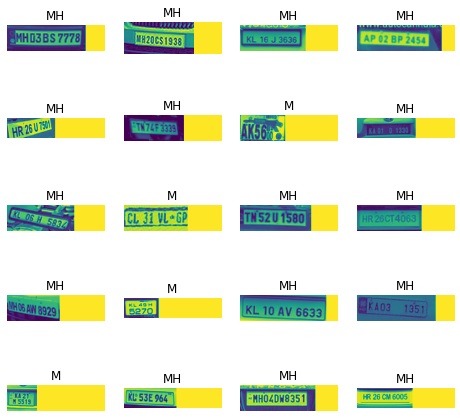

Character Accuracy: 6.56
Word Accuracy: 0.00


In [14]:
args['imgdir'] = 'test'
args['data'] = PlateDataset(args)
resume_file = os.path.join(args['save_dir'], args['name'], 'best.ckpt')
if os.path.isfile(resume_file):
    print('Loading model %s'%resume_file)
    checkpoint = torch.load(resume_file)
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    args['model'] = model
    ca, wa = get_accuracy(args)
    print("Character Accuracy: %.2f\nWord Accuracy: %.2f"%(ca, wa))
else:
    print("=> no checkpoint found at '{}'".format(os.path.join(args['save_dir'], args['name'])))
    print('Exiting')